In [1]:
from google.colab import drive
drive.mount('/content/drive')

# revise this. Make the current working directory to where the repository is (in your google drive)
%cd drive/MyDrive/22FallDeepLearning

Mounted at /content/drive
/content/drive/MyDrive/22FallDeepLearning


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt


In [3]:
from models import * 

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
summary(ResNet18().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [7]:
# I modified the ResNet-18 model by making all the number of channels to 1/2

class ModifiedResNetLarge(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNetLarge, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [8]:
modified_model_large = ModifiedResNetLarge(BasicBlock, [2, 2, 2, 2])

In [9]:
summary(modified_model_large.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [10]:
# I modified the ResNet-18 model by making all the number of channels to 1/2

class ModifiedResNet3Layers(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet3Layers, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [11]:
modified_model_3_layer = ModifiedResNet3Layers(BasicBlock, [2, 2, 2, 2])

In [12]:
summary(modified_model_3_layer.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 16, 16]          36,864
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]           4,096
       BatchNorm2d-8           [-1, 64, 16, 16]             128
        BasicBlock-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
       BasicBlock-14           [-1, 64,

In [13]:
# I modified the ResNet-18 model by making all the number of channels to 1/2

class ModifiedResNetSmall(nn.Module):
# class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNetSmall, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [14]:
modified_model_small = ModifiedResNetSmall(BasicBlock, [2, 2, 2, 2])

In [15]:
summary(modified_model_small.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

# Load data

In [16]:
import sklearn

In [17]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [18]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test) # download the train set with test transform as the validation set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [19]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(modified_model_small.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# training

In [20]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
# Training
def train(epoch, model, trainloader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return train_loss/(batch_idx+1), 100.*correct/total

In [22]:
def test(epoch, model, testloader, fold = None):
    global best_acc
    global patience
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        state = {'model': model.state_dict(),'acc': acc,'epoch': epoch}
        if not fold:
          torch.save(state, f'./checkpoint/trainAll_ckpt.pth')
        else:
          torch.save(state, f'./checkpoint/fold{fold}_ckpt.pth')
        best_acc = acc
        patience = 0
    else:
      patience += 1
    
    return test_loss/(batch_idx+1), acc

In [23]:
def train_all(N_EPOCHS, model, t_loss_arr, v_loss_arr, lr=0.1, N_patience=5):
  global best_acc
  global patience # to record how many epochs are not improving

  # make the directory for storing checkpoint
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=128)
  testloader = torch.utils.data.DataLoader(testset, batch_size=100)

  # model = ModifiedResNet(BasicBlock, [2, 2, 2, 2])
  # model = ResNet18()
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)
  patience = 0
  best_acc = 0
  for epoch in range(N_EPOCHS):
    start_time = time.time()
    if patience == N_patience:
      print(f"early stop at epoch {epoch}")
      break
    train_loss, train_acc = train(epoch, model, trainloader, optimizer)
    test_loss, test_acc = test(epoch, model, testloader)
    t_loss_arr.append(train_loss)
    v_loss_arr.append(test_loss)
    scheduler.step()
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'lr={scheduler.get_last_lr()}')
    print(f'Epoch: {epoch+1} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f"epoch{epoch+1} train loss: {train_loss} train acc: {train_acc} test acc: {test_acc}")

In [24]:
train_small = []
valid_small = []
train_all(30, modified_model_small, train_small, valid_small, lr=0.1, N_patience=5)

  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 40s
epoch1 train loss: 1.6772763780925586 train acc: 37.442 test acc: 47.9


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 37s
epoch2 train loss: 1.1917832916045128 train acc: 56.63 test acc: 60.98


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 37s
epoch3 train loss: 0.9433890466799821 train acc: 66.704 test acc: 69.15


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 38s
epoch4 train loss: 0.7758587801547916 train acc: 72.88 test acc: 72.36


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 37s
epoch5 train loss: 0.6673135836715893 train acc: 76.654 test acc: 76.72


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 38s
epoch6 train loss: 0.6070884376230752 train acc: 79.03 test acc: 75.49


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 37s
epoch7 train loss: 0.5592649979969425 train acc: 80.882 test acc: 78.23


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 38s
epoch8 train loss: 0.5314352494066633 train acc: 81.57 test acc: 77.49


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 37s
epoch9 train loss: 0.4989066271068495 train acc: 82.814 test acc: 79.3


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 38s
epoch10 train loss: 0.4762876301317874 train acc: 83.74 test acc: 81.26


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 37s
epoch11 train loss: 0.4507400042870465 train acc: 84.508 test acc: 79.38


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 37s
epoch12 train loss: 0.42947361185727523 train acc: 85.248 test acc: 83.09


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 37s
epoch13 train loss: 0.40682386326820347 train acc: 86.126 test acc: 82.14


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 37s
epoch14 train loss: 0.38577688197650567 train acc: 86.714 test acc: 83.56


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 37s
epoch15 train loss: 0.36042594814392004 train acc: 87.532 test acc: 82.42


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 37s
epoch16 train loss: 0.3367598651696349 train acc: 88.416 test acc: 84.99


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 38s
epoch17 train loss: 0.3208838565956296 train acc: 88.8 test acc: 83.48


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 37s
epoch18 train loss: 0.29309494084561877 train acc: 89.916 test acc: 85.08


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 37s
epoch19 train loss: 0.2699143428479314 train acc: 90.71 test acc: 85.61


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 37s
epoch20 train loss: 0.24356581367876218 train acc: 91.706 test acc: 87.69


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 37s
epoch21 train loss: 0.22151562588675247 train acc: 92.282 test acc: 86.86


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 36s
epoch22 train loss: 0.1928126360182567 train acc: 93.362 test acc: 87.72


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 37s
epoch23 train loss: 0.1674191507575152 train acc: 94.246 test acc: 88.95


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 37s
epoch24 train loss: 0.14030321749389324 train acc: 95.282 test acc: 89.62


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 37s
epoch25 train loss: 0.11568338337266232 train acc: 96.108 test acc: 90.52


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 36s
epoch26 train loss: 0.09396178444461598 train acc: 96.932 test acc: 90.9


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 37s
epoch27 train loss: 0.0777609545947112 train acc: 97.466 test acc: 91.56


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 36s
epoch28 train loss: 0.06646494060287923 train acc: 97.824 test acc: 91.67


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 37s
epoch29 train loss: 0.0567883156273333 train acc: 98.304 test acc: 91.91


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 36s
epoch30 train loss: 0.053647009858294674 train acc: 98.374 test acc: 91.86


In [25]:
train_large = []
valid_large = []
train_all(30, modified_model_large, train_large, valid_large, lr=0.1, N_patience=5)

  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 55s
epoch1 train loss: 1.6798661063089395 train acc: 37.756 test acc: 51.63


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 55s
epoch2 train loss: 1.1697100500011688 train acc: 57.546 test acc: 62.18


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 55s
epoch3 train loss: 0.9104132905335682 train acc: 67.64 test acc: 70.63


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 55s
epoch4 train loss: 0.7400568425655365 train acc: 74.144 test acc: 74.15


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 54s
epoch5 train loss: 0.6329640675993526 train acc: 78.082 test acc: 76.44


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 55s
epoch6 train loss: 0.5670319224714928 train acc: 80.274 test acc: 78.18


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 55s
epoch7 train loss: 0.5255369555462351 train acc: 81.81 test acc: 78.5


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 55s
epoch8 train loss: 0.493426704574424 train acc: 83.268 test acc: 81.37


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 55s
epoch9 train loss: 0.46593846514096954 train acc: 84.058 test acc: 79.78


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 54s
epoch10 train loss: 0.4375686370350821 train acc: 85.038 test acc: 80.04


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 54s
epoch11 train loss: 0.412403053754126 train acc: 85.784 test acc: 81.58


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 55s
epoch12 train loss: 0.3882290993810005 train acc: 86.624 test acc: 80.18


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 55s
epoch13 train loss: 0.36611664546725087 train acc: 87.45 test acc: 84.58


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 55s
epoch14 train loss: 0.34550694477222765 train acc: 88.306 test acc: 85.01


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 55s
epoch15 train loss: 0.3213036157514738 train acc: 88.912 test acc: 85.68


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 55s
epoch16 train loss: 0.2948712941706943 train acc: 89.808 test acc: 81.53


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 55s
epoch17 train loss: 0.27323258365206704 train acc: 90.596 test acc: 86.47


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 55s
epoch18 train loss: 0.2541942479055556 train acc: 91.29 test acc: 87.73


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 54s
epoch19 train loss: 0.22864471164429584 train acc: 92.21 test acc: 86.74


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 55s
epoch20 train loss: 0.20151871907741517 train acc: 93.154 test acc: 88.56


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 55s
epoch21 train loss: 0.17613934329174974 train acc: 93.95 test acc: 89.31


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 55s
epoch22 train loss: 0.15116431244918146 train acc: 94.918 test acc: 89.51


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 54s
epoch23 train loss: 0.12582478168256142 train acc: 95.788 test acc: 90.19


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 54s
epoch24 train loss: 0.09927680830726081 train acc: 96.61 test acc: 90.59


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 55s
epoch25 train loss: 0.0802889645261609 train acc: 97.316 test acc: 91.93


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 55s
epoch26 train loss: 0.05894927537578451 train acc: 98.082 test acc: 91.95


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 54s
epoch27 train loss: 0.04673147588001226 train acc: 98.548 test acc: 92.63


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 54s
epoch28 train loss: 0.03554391518861646 train acc: 98.972 test acc: 92.81


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 55s
epoch29 train loss: 0.029372838377009342 train acc: 99.186 test acc: 93.03


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 55s
epoch30 train loss: 0.027052405858388567 train acc: 99.29 test acc: 93.12


In [ ]:
fig = plt.figure()
plt.title('loss over different models - training')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,31), train_small, label='small')
plt.plot(range(1,31), train_large, label='large')
# plt.plot(range(1,31), train_3, label='3 layer')
plt.legend()
plt.show()
fig.savefig('training_loss_30.png')

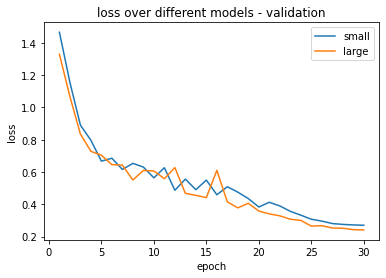

In [27]:
fig = plt.figure()

plt.title('loss over different models - validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,31), valid_small, label='small')
plt.plot(range(1,31), valid_large, label='large')
plt.plot(range(1,31), valid_3, label='3 layer')
plt.legend()
plt.show()

fig.savefig('validation_loss_30.png')

In [26]:
train_3 = []
valid_3 = []
train_all(30, modified_model_3_layer, train_3, valid_3, lr=0.1, N_patience=5)

  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 32s
epoch1 train loss: 1.6489063702580873 train acc: 39.254 test acc: 48.3


  0%|          | 0/391 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 33s
epoch2 train loss: 1.1690544079026908 train acc: 57.782 test acc: 61.71


  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: ignored